In [71]:
import pandas as pd



## VALUATIONS

In [72]:
# Read valuations
valuations_path = 'datasets/player_valuations.csv'

# Read the CSV file into a pandas DataFrame
df_val = pd.read_csv(valuations_path)

#drop unesseccary columns
df_val = df_val.drop(columns=["datetime", "dateweek"])


## CONSTANTS

In [73]:
#Get latest season end year
latest_date = df_val['date'].max()
latest_year = int(latest_date[0:4])
latest_year

MONTH_START = "-08-10"
MONTH_END = "-06-10"

## PLAYER STATS

In [74]:
# Read stats
"""
Columns
appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
"""
stats_path = 'datasets/appearances.csv'

# Read the CSV file into a pandas DataFrame
df_stats = pd.read_csv(stats_path)

#drop unesseccary columns
#TBD

## CATEGORICAL DATA

In [75]:
"""
CATEGORICAL DATA HANDLING
Columns
player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
"""

# Read player categorical data
categorical_path = 'datasets/players.csv'

df_categorical = pd.read_csv(categorical_path)

#drop redundant columns
#comment: dropping sub-position as all players only have one
df_cat = df_categorical.drop(
    columns=[
        "first_name", "last_name", "name", "player_code", "city_of_birth", "image_url", "url", "highest_market_value_in_eur", "current_club_name",
        "agent_name", "current_club_domestic_competition_id", "market_value_in_eur", "current_club_domestic_competition_id", "current_club_id", "last_season", "sub_position"
        ])


#Change date of birth to age
df_cat['date_of_birth'] = pd.to_datetime(df_cat['date_of_birth'])
def calculate_age(birthdate):
    today = pd.to_datetime('today')
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age

df_cat['age'] = df_cat['date_of_birth'].apply(calculate_age)

#date of birth now redundant
df_cat = df_cat.drop(columns=["date_of_birth"])


# Fill NaN values in 'height_in_cm' with the mean
mean_value = df_cat['height_in_cm'].mean()
df_cat['height_in_cm'].fillna(mean_value, inplace=True)

#Fill NaN values in col Foot with 'right'
most_frequent_value = df_cat['foot'].mode().iloc[0]
df_cat['foot'].fillna(most_frequent_value, inplace=True)

## CLUB GAMES

In [76]:
"""
Club games data handling
Columns: game_id,club_id,own_goals,own_position,own_manager_name,opponent_id,opponent_goals,opponent_position,opponent_manager_name,hosting,is_win
"""

# Read player categorical data
club_games_path = 'datasets/club_games.csv'
game_lineups_path = 'datasets/game_lineups.csv'
games_path = 'datasets/games.csv'


df_club_games = pd.read_csv(club_games_path)
df_game_lineups = pd.read_csv(game_lineups_path)
df_games = pd.read_csv(games_path)


# Use boolean indexing to filter the DataFrame
game_ids_last_season = df_games[(df_games['date'] >= str(latest_year-1) + MONTH_START) & (df_games['date'] <= str(latest_year) + MONTH_END)]

# Get the game_id values for the filtered DataFrame
game_ids_in_range = game_ids_last_season['game_id'].tolist()

df_club_games_last_season = df_club_games[df_club_games['game_id'].isin(game_ids_in_range)]
df_game_line_ups_last_season = df_game_lineups[df_game_lineups['game_id'].isin(game_ids_in_range)]



df_club_games_last_season

,game_id,club_id,own_goals,own_position,own_manager_name,opponent_id,opponent_goals,opponent_position,opponent_manager_name,hosting,is_win
3524,3825466,418,2,NaN,Carlo Ancelotti,24,0,NaN,Oliver Glasner,Home,1
3529,3828437,678,1,3.0,Uwe Rösler,369,0,10.0,Freyr Alexandersson,Home,1
3530,3828449,2414,2,6.0,Jens Berthel Askou,678,1,4.0,Uwe Rösler,Home,1
3531,3828459,865,0,8.0,Albert Capellas,1053,2,10.0,Lars Friis,Home,0
3532,3828483,2414,0,8.0,Jens Berthel Askou,1053,0,11.0,Erik Hamrén,Home,0
...,...,...,...,...,...,...,...,...,...,...,...
130540,4072488,36,3,3.0,NaN,7775,0,19.0,NaN,Away,1
130541,4072493,7775,0,19.0,NaN,589,3,12.0,NaN,Away,0
130542,4080529,46,2,NaN,Simone Inzaghi,430,1,NaN,Vincenzo Italiano,Away,1
130741,4001330,131,3,NaN,Xavi,418,1,NaN,Carlo Ancelotti,Away,1


## EDA / DATA HANDLING

Fix contract_expiration

In [77]:
#Change contract expiration date to see how many months they have left at end of season
df_cat['contract_expiration_date'] = pd.to_datetime(df_cat['contract_expiration_date'])

current_date = pd.to_datetime(str(latest_year) + MONTH_END) #get latest date we are looking at

# Calculate the difference in months between the contract expiration date and the current date
# Calculate the difference in days first
df_cat['days_left'] = (df_cat['contract_expiration_date'] - current_date).dt.days.fillna(0)

# Convert days to months by dividing by the average number of days per month
# The average number of days in a month is approximately 30.44
df_cat['months_left'] = df_cat['days_left'] / 30.44

# Optional: If you want to round to the nearest whole number
df_cat['months_left'] = df_cat['months_left'].round().astype(int)

#contract expiration now redundant
df_cat = df_cat.drop(columns=["contract_expiration_date", "days_left"])

# Set negative values to zero because there will be some outgoing contracts at end of seasons
df_cat['months_left'] = df_cat['months_left'].clip(lower=0)

Only use last season and top 5 leagues in the world

In [78]:
#Select only specific leagues
competition_column = 'player_club_domestic_competition_id'
competitions = ["IT1", "GB1", "FR1", "L1", "ES1"]

#Take values from only last season
date_column = "date"
max_date_last_season = str(latest_year) + MONTH_END
min_date_last_season = str(latest_year-1) + MONTH_START

# Create a new DataFrame containing only rows where the 'column_name' matches the 'desired_value'
df_val_last_season = df_val[(df_val[competition_column].isin(competitions)) 
                                 & (df_val[date_column] >= min_date_last_season)
                                 & (df_val[date_column] <= max_date_last_season)]

df_stats_last_season = df_stats[(df_stats[date_column] >= min_date_last_season)
                                 & (df_stats[date_column] <= max_date_last_season)]

#Sort based on date
df_sorted = df_val_last_season.sort_values(by=['player_id', 'date'], ascending=[True, False])

# Drop duplicates, keeping the first entry for each 'playerID'
df_latest_valuations_last_season = df_sorted.drop_duplicates(subset='player_id', keep='first')

Select club game wins last season only

In [79]:
#aggregate stats for last season
df_club_games_last_season['clean_sheets'] = (df_club_games_last_season['opponent_goals'] == 0).astype(int)

# Display the updated DataFrame
print(df_aggregated_club_games)

df_aggregated_club_games= df_club_games_last_season.groupby('club_id').agg({
    'own_goals': 'sum',
    'opponent_goals': 'sum',
    'is_win': 'sum',
    'clean_sheets': 'sum'
}).reset_index()


df_aggregated_club_games['current_club_id'] = df_aggregated_club_games['club_id']

df_aggregated_club_games = df_aggregated_club_games.drop(columns=["club_id"])


     own_goals  opponent_goals  is_win  current_club_id
0           50              55      10                3
1            7               5       2                4
2           79              58      25                5
3            7               8       2                7
4            7               9       2                9
..         ...             ...     ...              ...
951          0               1       0           102243
952          4               4       1           102249
953          0               3       0           102250
954          3               5       1           102251
955          1               2       0           102261

[956 rows x 4 columns]


/var/folders/np/5mm2p41j3015kfgd1xftmc1c0000gn/T/ipykernel_2580/3913663735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_club_games_last_season['clean_sheets'] = (df_club_games_last_season['opponent_goals'] == 0).astype(int)


Aggregate stats for each player over the specific season

In [80]:
#aggregate stats for last season
df_aggregated_stats_last_season = df_stats_last_season.groupby('player_id').agg({
    'yellow_cards': 'sum',
    'red_cards': 'sum',
    'goals': 'sum',
    'assists': 'sum',
    'minutes_played': 'sum',
    'player_name': 'first' 
}).reset_index()

In [81]:
"""
STATS DATA HANDLING
"""

#df_aggregated_stats_last_season = df_aggregated_stats_last_season.drop(columns=["yellow_cards"])

'\nSTATS DATA HANDLING\n'

Merge all dataframes together

In [82]:
#Merge all dataframes together
df_val_stats_last_season = pd.merge(df_latest_valuations_last_season, df_aggregated_stats_last_season, on='player_id', how='inner')
df_val_stats_cat_last_season = pd.merge(df_val_stats_last_season, df_cat, on='player_id', how="inner")
df_features = pd.merge(df_val_stats_cat_last_season, df_aggregated_club_games, on='current_club_id', how="inner")



## Final columns

In [83]:
df_features

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id,yellow_cards,red_cards,goals,assists,minutes_played,...,country_of_citizenship,position,foot,height_in_cm,age,months_left,own_goals,opponent_goals,is_win,clean_sheets
0,3333,2022-11-03,2000000,1237.0,GB1,3,0,0,2,1238,...,England,Midfield,right,175.0,37.0,13,98,66,23,15
1,43530,2022-11-03,1500000,1237.0,GB1,0,0,3,1,759,...,England,Midfield,both,172.0,35.0,13,98,66,23,15
2,67063,2022-11-03,8000000,1237.0,GB1,0,0,7,3,2053,...,England,Attack,right,185.0,33.0,13,98,66,23,15
3,73564,2023-03-16,1000000,1237.0,GB1,1,0,0,1,1890,...,England,Goalkeeper,right,188.0,33.0,37,98,66,23,15
4,82873,2022-11-03,8000000,1237.0,GB1,6,0,8,10,3762,...,Germany,Midfield,right,181.0,32.0,25,98,66,23,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,533662,2023-06-01,12000000,350.0,GB1,0,0,0,0,65,...,England,Attack,right,175.0,22.0,49,12,10,4,2
2711,546712,2022-11-14,3500000,350.0,GB1,3,0,2,1,869,...,Tunisia,Midfield,both,188.0,22.0,37,12,10,4,2
2712,554251,2023-03-27,3500000,350.0,GB1,1,0,1,1,1716,...,Algeria,Defender,left,176.0,22.0,13,12,10,4,2
2713,663581,2022-11-07,7000000,350.0,GB1,12,0,1,1,2665,...,Brazil,Midfield,right,187.0,24.0,49,12,10,4,2


Analysis on wether the feature affects the valuation or not

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

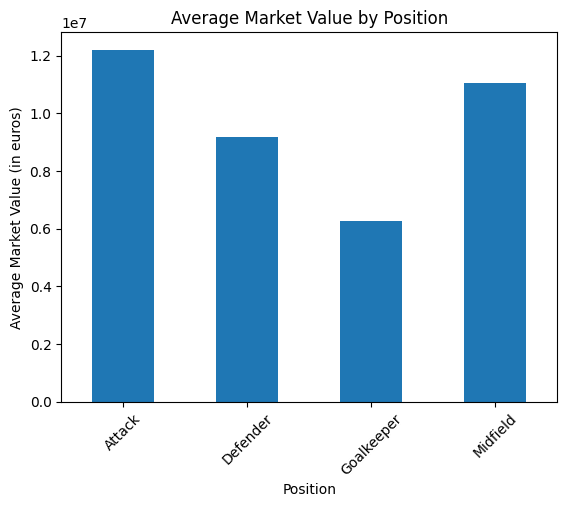

In [85]:
df_features = df_features[df_features['position'] != "Missing"]
grouped_data = df_features.groupby('position')['market_value_in_eur'].mean()

# Plotting
grouped_data.plot(kind='bar')
plt.title('Average Market Value by Position')
plt.xlabel('Position')
plt.ylabel('Average Market Value (in euros)')
plt.xticks(rotation=45)  # Rotates the labels on x-axis for better readability
plt.show()

Positions obviousley affects market value and will be accounted for in the model.

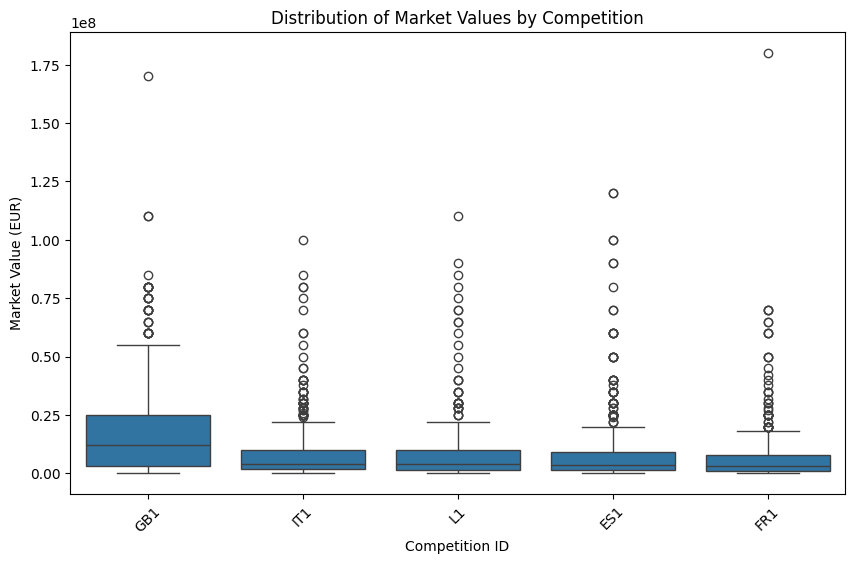

In [86]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='player_club_domestic_competition_id', y='market_value_in_eur', data=df_features)

plt.xlabel('Competition ID')
plt.ylabel('Market Value (EUR)')
plt.title('Distribution of Market Values by Competition')
plt.xticks(rotation=45)  # Rotates the labels on x-axis for better readability

plt.show()

GB1 has a relatively wide interquartile range, indicating a larger variation in market values compared to other competitions.
All competitions have outliers above the upper whisker, indicating some players with market values significantly higher than the general population within those competitions.
The median line within each box can give you an idea of the central tendency of market values within each competition.

Which league the player plays in is therefore relevant for the market value.

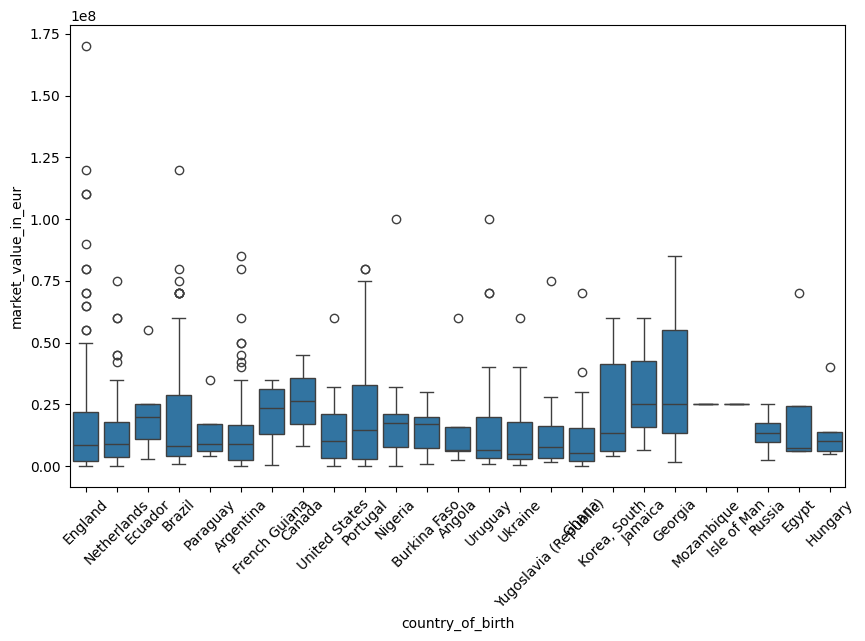

In [87]:
# Group by country of birth and get the average market value
country_market_values = df_features.groupby('country_of_birth')['market_value_in_eur'].mean().sort_values(ascending=False)

# Take the top N countries
top_countries = country_market_values.head(25)  # Adjust N as needed

# Filter the original DataFrame to include only the top N countries
top_countries_df = df_features[df_features['country_of_birth'].isin(top_countries.index)]

# Now plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='country_of_birth', y='market_value_in_eur', data=top_countries_df)
plt.xticks(rotation=45)
plt.show()

Very random and it seems like country of birth is wrong. Dropping column...

In [88]:
df_features = df_features.drop(columns=["country_of_birth", "country_of_citizenship"])

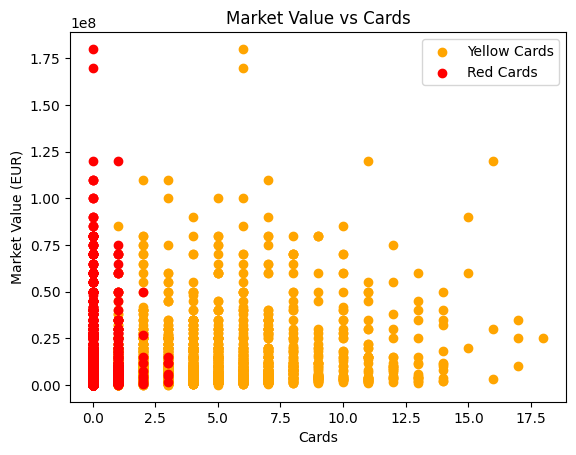

In [89]:
plt.scatter(df_features['yellow_cards'], df_features['market_value_in_eur'], label='Yellow Cards', color='orange')
plt.scatter(df_features['red_cards'], df_features['market_value_in_eur'], label='Red Cards', color='red')
plt.title('Market Value vs Cards')
plt.xlabel('Cards')
plt.ylabel('Market Value (EUR)')
plt.legend()
plt.show()

Market value seems to be negatively correlated with many red and yellow cards. Drop yellow cards but keep red.

In [90]:
df_features

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id,yellow_cards,red_cards,goals,assists,minutes_played,player_name,position,foot,height_in_cm,age,months_left,own_goals,opponent_goals,is_win,clean_sheets
0,3333,2022-11-03,2000000,1237.0,GB1,3,0,0,2,1238,James Milner,Midfield,right,175.0,37.0,13,98,66,23,15
1,43530,2022-11-03,1500000,1237.0,GB1,0,0,3,1,759,Adam Lallana,Midfield,both,172.0,35.0,13,98,66,23,15
2,67063,2022-11-03,8000000,1237.0,GB1,0,0,7,3,2053,Danny Welbeck,Attack,right,185.0,33.0,13,98,66,23,15
3,73564,2023-03-16,1000000,1237.0,GB1,1,0,0,1,1890,Jason Steele,Goalkeeper,right,188.0,33.0,37,98,66,23,15
4,82873,2022-11-03,8000000,1237.0,GB1,6,0,8,10,3762,Pascal Groß,Midfield,right,181.0,32.0,25,98,66,23,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,533662,2023-06-01,12000000,350.0,GB1,0,0,0,0,65,Cameron Archer,Attack,right,175.0,22.0,49,12,10,4,2
2711,546712,2022-11-14,3500000,350.0,GB1,3,0,2,1,869,Anis Slimane,Midfield,both,188.0,22.0,37,12,10,4,2
2712,554251,2023-03-27,3500000,350.0,GB1,1,0,1,1,1716,Yasser Larouci,Defender,left,176.0,22.0,13,12,10,4,2
2713,663581,2022-11-07,7000000,350.0,GB1,12,0,1,1,2665,Vini Souza,Midfield,right,187.0,24.0,49,12,10,4,2


/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


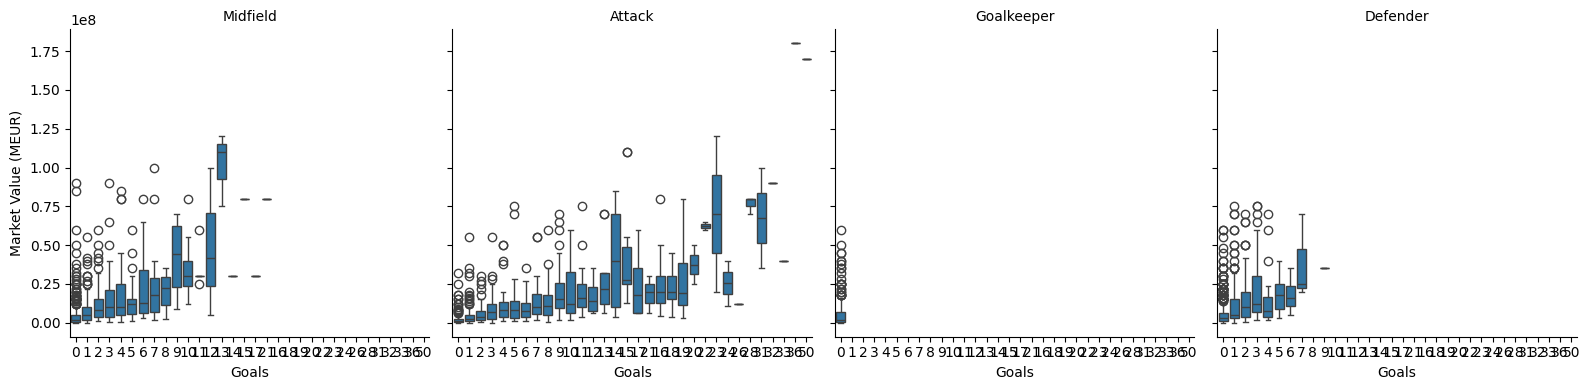

In [91]:
# Create separate box plots for market value against goals for each position

g = sns.FacetGrid(df_features, col="position", col_wrap=4, height=4)
g.map(sns.boxplot, "goals", "market_value_in_eur")

# Adjust titles and labels
g.set_axis_labels("Goals", "Market Value (MEUR)")
g.set_titles(col_template="{col_name}")
g.tight_layout()

plt.show()

Goals is, obviousley, correlated with market value, even for defenders it seems.

/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


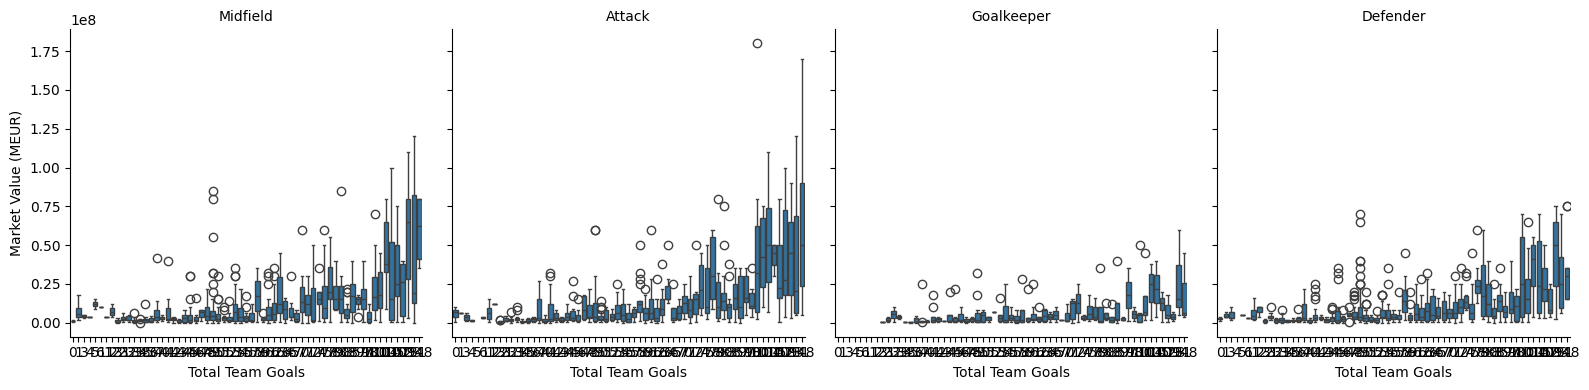

In [93]:
# Create separate box plots for market value against total team goals for each position

g = sns.FacetGrid(df_features, col="position", col_wrap=4, height=4)
g.map(sns.boxplot, "own_goals", "market_value_in_eur")

# Adjust titles and labels
g.set_axis_labels("Total Team Goals", "Market Value (MEUR)")
g.set_titles(col_template="{col_name}")
g.tight_layout()

plt.show()

Total team goals also affects player price. We believe this attribute is catching player performances up until the second to last pass before a goal, therefore is affects midfielders the same way it affects attackers. The variation is not as high with defenders, but the trend seems to be positive nonetheless.

/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


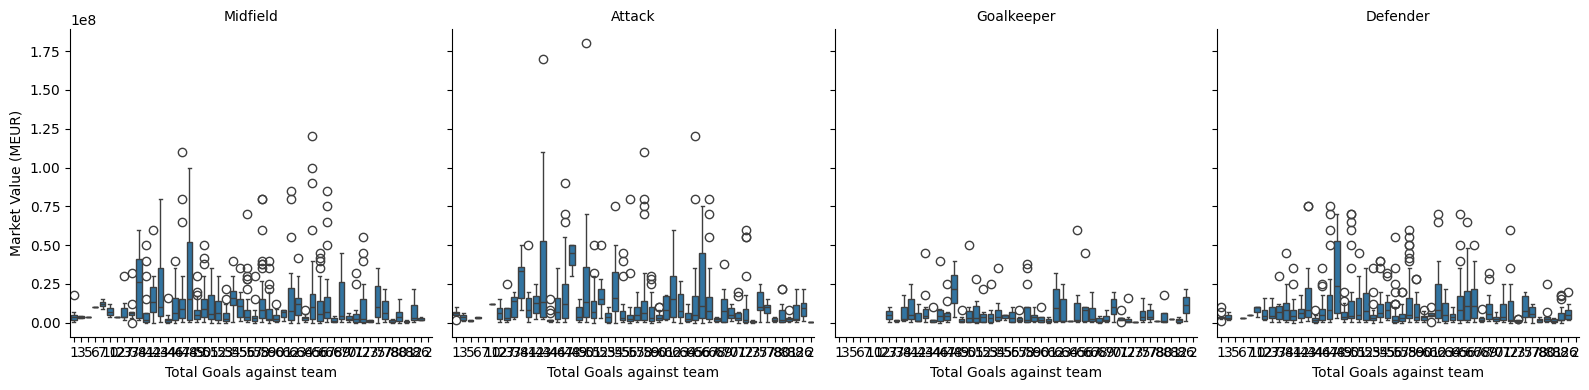

In [95]:
# Create separate box plots for market value against total goals scored against the team for each position

g = sns.FacetGrid(df_features, col="position", col_wrap=4, height=4)
g.map(sns.boxplot, "opponent_goals", "market_value_in_eur")

# Adjust titles and labels
g.set_axis_labels("Total Goals against team", "Market Value (MEUR)")
g.set_titles(col_template="{col_name}")
g.tight_layout()

plt.show()

Goals scored against the team was thought to have large impact on player valuations, in particular goalkeepers and defenders. Surprisingly, there is not a clear trend of how it affects market value of the players. We keep it for now until further analysis are done.

/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


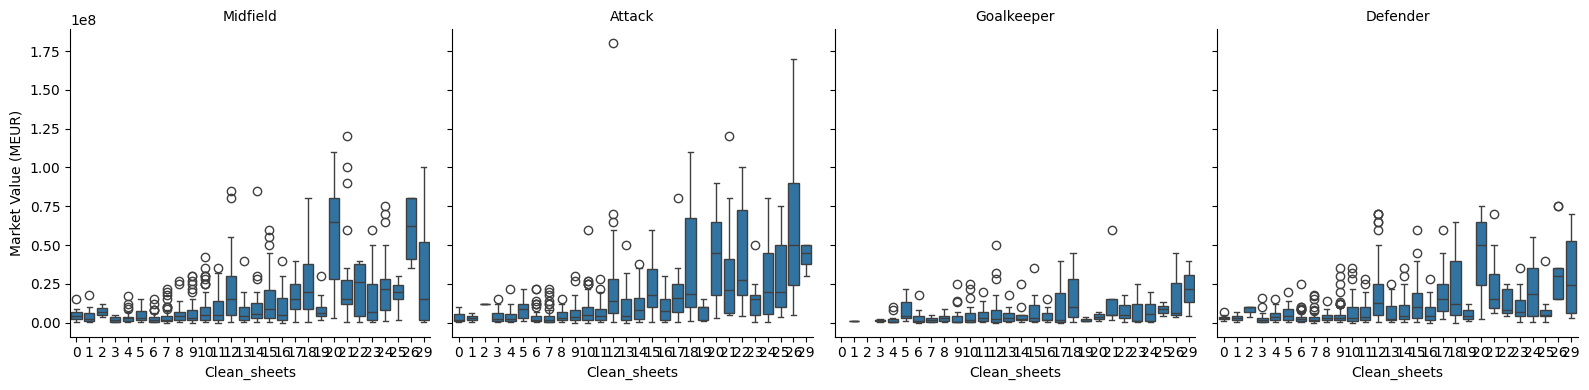

In [96]:
# Create separate box plots for market value against clean sheets for each position

g = sns.FacetGrid(df_features, col="position", col_wrap=4, height=4)
g.map(sns.boxplot, "clean_sheets", "market_value_in_eur")

# Adjust titles and labels
g.set_axis_labels("Clean_sheets", "Market Value (MEUR)")
g.set_titles(col_template="{col_name}")
g.tight_layout()

plt.show()

There seems to be a positive trend for value of goalkeepers and defenders with amount of clean_sheets, but also for attackers and midfielders; this probably has to do with that having a clean_sheet means there's a higher chance the match was won.

/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


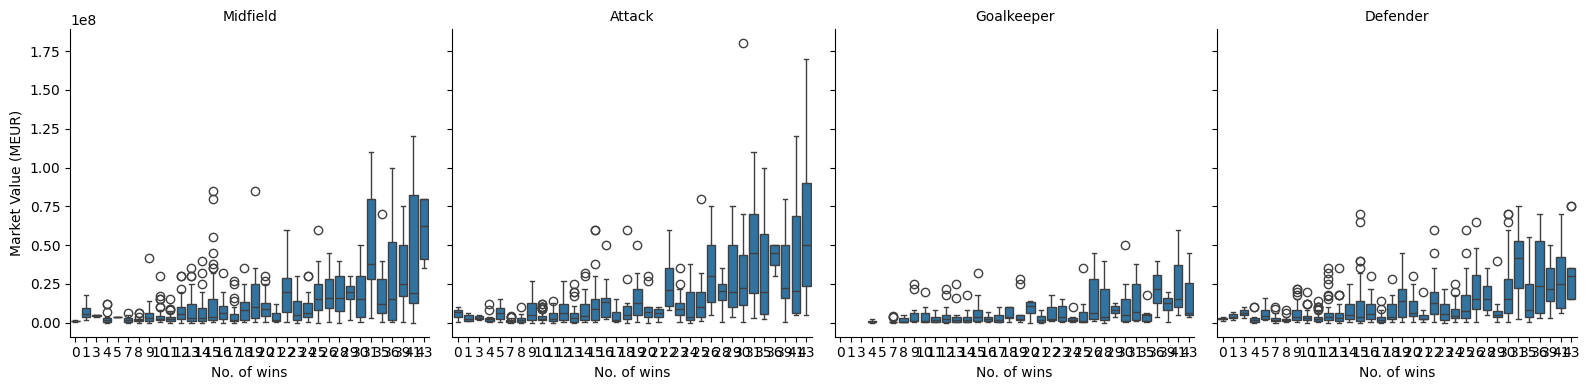

In [98]:
# Create separate box plots for market value against no. of wins for each position

g = sns.FacetGrid(df_features, col="position", col_wrap=4, height=4)
g.map(sns.boxplot, "is_win", "market_value_in_eur")

# Adjust titles and labels
g.set_axis_labels("No. of wins", "Market Value (MEUR)")
g.set_titles(col_template="{col_name}")
g.tight_layout()

plt.show()

As thought, positive correlation for all positions.

/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


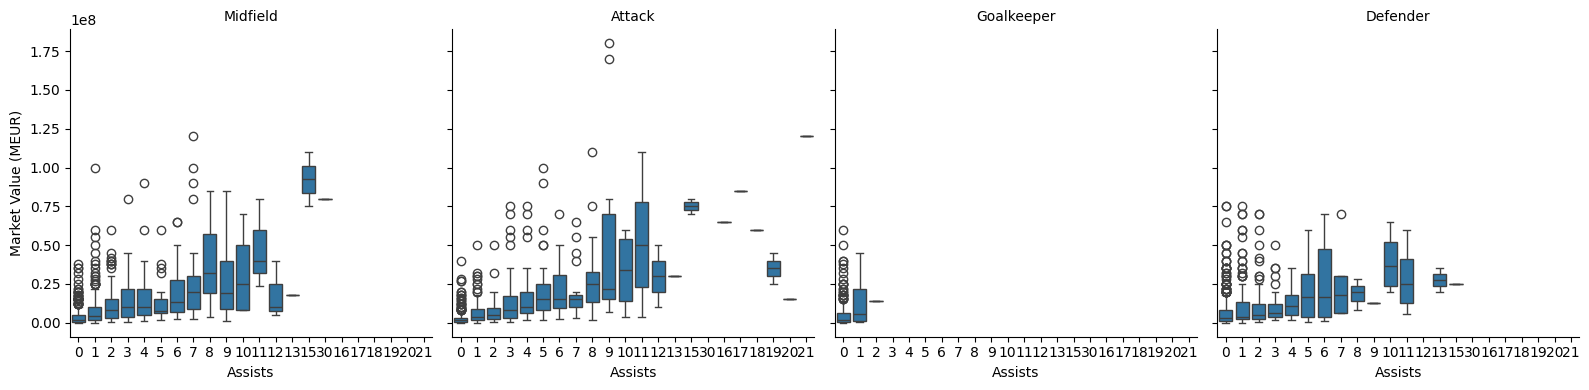

In [92]:
# Create separate box plots for market value against assists for each position

g = sns.FacetGrid(df_features, col="position", col_wrap=4, height=4)
g.map(sns.boxplot, "assists", "market_value_in_eur")

# Adjust titles and labels
g.set_axis_labels("Assists", "Market Value (MEUR)")
g.set_titles(col_template="{col_name}")
g.tight_layout()

plt.show()

Same conclusion as for goals

<Figure size 1000x600 with 0 Axes>

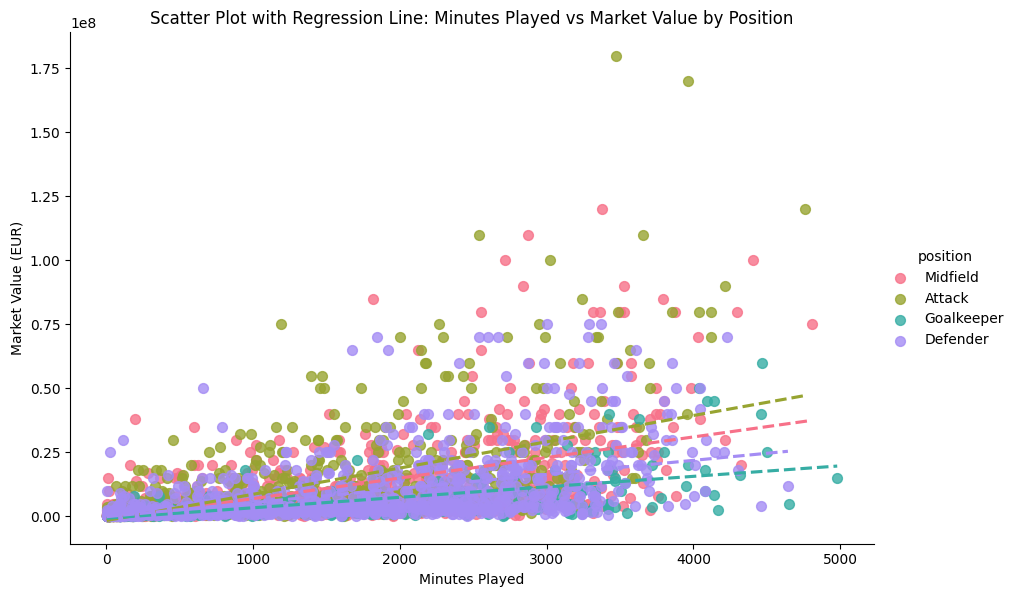

In [103]:
# Set the color palette for each position
palette = sns.color_palette("husl", n_colors=len(df_features['position'].unique()))

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.lmplot(x='minutes_played', y='market_value_in_eur', hue='position', data=df_features, scatter_kws={'s': 50}, line_kws={'linestyle':'--'}, ci=None, palette=palette, height=6, aspect=1.5)

# Adjust titles and labels
plt.title('Scatter Plot with Regression Line: Minutes Played vs Market Value by Position')
plt.xlabel('Minutes Played')
plt.ylabel('Market Value (EUR)')

plt.show()

As expected, positive correlation between minutes played and market value. However, most clear for Attackers and midfields

<Figure size 1000x600 with 0 Axes>

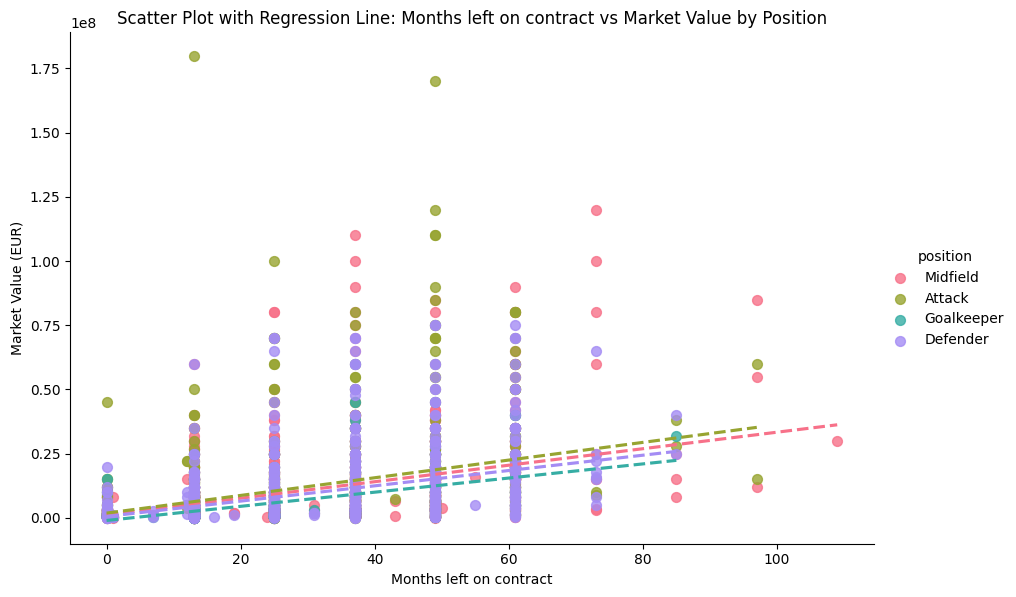

In [105]:
# Set the color palette for each position
palette = sns.color_palette("husl", n_colors=len(df_features['position'].unique()))

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.lmplot(x='months_left', y='market_value_in_eur', hue='position', data=df_features, scatter_kws={'s': 50}, line_kws={'linestyle':'--'}, ci=None, palette=palette, height=6, aspect=1.5)

# Adjust titles and labels
plt.title('Scatter Plot with Regression Line: Months left on contract vs Market Value by Position')
plt.xlabel('Months left on contract')
plt.ylabel('Market Value (EUR)')

plt.show()

Same as for minutes played

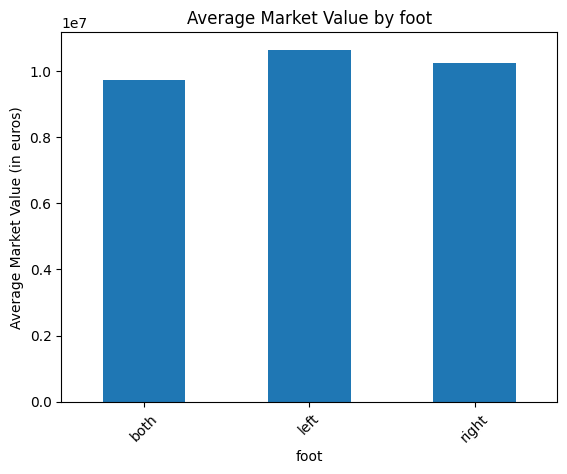

In [106]:
grouped_data = df_features.groupby('foot')['market_value_in_eur'].mean()

# Plotting
grouped_data.plot(kind='bar')
plt.title('Average Market Value by foot')
plt.xlabel('foot')
plt.ylabel('Average Market Value (in euros)')
plt.xticks(rotation=45)  # Rotates the labels on x-axis for better readability
plt.show()

No actual difference, dropping columns?